In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("assignment2_cnn_rnn.ipynb")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms


%matplotlib inline
np.random.seed(42)
torch.manual_seed(42)

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [3]:
# ==========================================
# HELPER: TEXT PIPELINE
# We provide this so you can focus on the LSTM architecture.
# ==========================================
class SimpleTextPipeline:
    def __init__(self, vocabulary_size=1000, max_len=50):
        self.vocab_size = vocabulary_size
        self.max_len = max_len
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}

    def fit(self, texts):
        # Build freq dict
        counts = {}
        for text in texts:
            for word in text.lower().split():
                counts[word] = counts.get(word, 0) + 1

        # Sort by freq
        sorted_words = sorted(counts, key=counts.get, reverse=True)

        # Add to vocab up to limit
        for i, word in enumerate(sorted_words[:self.vocab_size-2]):
            idx = i + 2
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def transform(self, texts):
        # Convert text to padded indices
        batch = np.zeros((len(texts), self.max_len), dtype=int)
        for i, text in enumerate(texts):
            words = text.lower().split()[:self.max_len]
            for j, word in enumerate(words):
                batch[i, j] = self.word2idx.get(word, 1) # 1 is UNK
        return torch.tensor(batch, dtype=torch.long)

# Mock Data Generator (since we can't download IMDB in this grader environment easily)
def generate_mock_imdb_data(N=500, max_len=50):
    pos_words = ["good", "great", "amazing", "love", "fantastic", "masterpiece"]
    neg_words = ["bad", "terrible", "hate", "awful", "worst", "waste"]
    neutral_fillers = ["the", "this", "is", "a", "movie", "film", "acting", "story", "direction", "it"]

    texts = []
    labels = []

    for _ in range(N):
        is_pos = np.random.rand() > 0.5
        
        # Create a pool of words
        sentiment_word = np.random.choice(pos_words if is_pos else neg_words)
        contrast_word = np.random.choice(neg_words if is_pos else pos_words)
        
        # Randomly choose a "Hard" pattern
        pattern_type = np.random.choice(["negation", "contrast", "long_range"])
        
        if pattern_type == "negation":
            # "it was not good" -> label 0 even if "good" is present
            sentence = f"the movie was not {np.random.choice(pos_words)}"
            label = 0 # Forced negative by negation
            
        elif pattern_type == "contrast":
            # "The acting was great but the story was bad"
            sentence = f"the acting was {sentiment_word} but the script was {contrast_word}"
            label = 1 if is_pos else 0
            
        else: # long_range
            # Embed the sentiment word deep in neutral filler
            fillers = np.random.choice(neutral_fillers, 8)
            sentence = " ".join(fillers) + f" was actually {sentiment_word}"
            label = 1 if is_pos else 0

        texts.append(sentence)
        labels.append(label)

    return texts, torch.tensor(labels, dtype=torch.float32)

# Assignment 2: Deep Architectures (CNNs & RNNs)

**Duration:** 4 Weeks

In this assignment, we will dive deep into the two pillars of Deep Learning:
1.  **Spatial Learning:** Convolutional Neural Networks (CNNs) for images.
2.  **Temporal Learning:** Recurrent Neural Networks (RNNs/LSTMs) for sequences.

We will use a hybrid approach:
* **NumPy:** To understand the low-level mechanics of Convolution and RNN steps.
* **PyTorch:** To build deep, trainable models efficiently.

# Part 1: CNN Mechanics (NumPy)

## Question 1: Naive Convolution Forward Pass

The core of a CNN is the convolution operation. You will implement the sliding window mechanism manually.

Given:
* Input $X$: $(N, C, H, W)$
* Weights $W$: $(F, C, HH, WW)$
* Output Formula: $H_{out} = 1 + (H + 2P - HH) / S$

**Task:** Implement the nested loops to compute the output volume.

In [4]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with keys 'stride' and 'pad'

    Returns:
    - out: Output data, of shape (N, F, H', W')
    """
    out = None

    # Unpack dimensions
    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    stride = conv_param['stride']
    pad = conv_param['pad']

    # Check dimensions
    assert (H + 2 * pad - HH) % stride == 0, 'Height check failed'
    assert (W + 2 * pad - WW) % stride == 0, 'Width check failed'

    # 2. 计算输出尺寸 (H_out, W_out)
    H_out = 1 + (H + 2 * pad - HH) // stride
    W_out = 1 + (W + 2 * pad - WW) // stride

    # 3. 初始化输出和填充输入
    out = np.zeros((N, F, H_out, W_out))
    # np.pad 格式: ((n_before, n_after), (c_before, c_after), ...)
    # 我们只在 H 和 W 维度上填充
    x_pad = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), 'constant')

    # 4. 执行卷积 (嵌套循环)
    for n in range(N):              # 遍历每个样本
        for f in range(F):          # 遍历每个卷积核(Filter)
            for i in range(H_out):  # 遍历输出高度
                for j in range(W_out): # 遍历输出宽度
                    
                    # 确定当前窗口在输入数据上的切片位置
                    # 还要考虑 stride 带来的跳跃
                    vert_start = i * stride
                    vert_end = vert_start + HH
                    horiz_start = j * stride
                    horiz_end = horiz_start + WW
                    
                    # 取出对应的输入块 (Slice)
                    x_slice = x_pad[n, :, vert_start:vert_end, horiz_start:horiz_end]
                    
                    # 卷积操作：点积求和 + 偏置
                    # w[f] 是第 f 个卷积核，形状 (C, HH, WW)
                    out[n, f, i, j] = np.sum(x_slice * w[f]) + b[f]

    cache = (x, w, b, conv_param)
    return out, cache

In [5]:
grader.check("q1_conv_naive")

q1_conv_naive results: All test cases passed!

# Part 2: CNNs in PyTorch

Writing loops in Python is slow. Now let's use PyTorch's optimized `nn.Conv2d`.

## Question 2: LeNet-5 Architecture

Implement the classic LeNet architecture:
1. `Conv2d` (in=3, out=6, k=5) -> `ReLU` -> `MaxPool` (k=2, stride=2)
2. `Conv2d` (in=6, out=16, k=5) -> `ReLU` -> `MaxPool` (k=2, stride=2)
3. Flatten
4. `Linear` -> `ReLU` -> `Linear` -> `Linear`

In [7]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10, in_channels=3):
        super().__init__()
        # Layer 1: Conv (3->6) -> Pool
        # 输入 32x32 -> Conv(5x5) -> 28x28 -> Pool(2x2) -> 14x14
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2: Conv (6->16) -> Pool
        # 输入 14x14 -> Conv(5x5) -> 10x10 -> Pool(2x2) -> 5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # Fully connected layers
        # 展平后维度: 16通道 * 5高 * 5宽 = 400
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        # x shape: (Batch, C, 32, 32)

        # Block 1
        x = self.pool(F.relu(self.conv1(x)))  # -> (Batch, 6, 14, 14)

        # Block 2
        x = self.pool(F.relu(self.conv2(x)))  # -> (Batch, 16, 5, 5)

        # Flatten
        # start_dim=1 表示保留 Batch 维度，把后面的 C,H,W 展平
        x = torch.flatten(x, 1)

        # Linear layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 最后一层通常不加激活函数，因为 CrossEntropyLoss 会处理
        return x



In [8]:
grader.check("q2_lenet")

q2_lenet results: All test cases passed!

In [9]:
# Train LeNet on MNIST

# Hyperparameters
BATCH_SIZE = 64
LR = 0.01
EPOCHS = 5

model = LeNet(in_channels=1)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Transform to normalize and pad 28x28 to 32x32 (standard LeNet input)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=BATCH_SIZE, shuffle=False)

train_losses = []
test_accs = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Evaluate
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    
    accuracy = 100. * correct / len(test_loader.dataset)
    train_losses.append(running_loss / len(train_loader))
    test_accs.append(accuracy)
    print(f"Epoch {epoch+1}: Loss: {train_losses[-1]:.4f}, Test Acc: {accuracy:.2f}%")

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 180kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.34MB/s]


Epoch 1: Loss: 0.2792, Test Acc: 97.13%
Epoch 2: Loss: 0.0595, Test Acc: 98.28%
Epoch 3: Loss: 0.0412, Test Acc: 98.58%
Epoch 4: Loss: 0.0336, Test Acc: 98.67%
Epoch 5: Loss: 0.0258, Test Acc: 98.85%


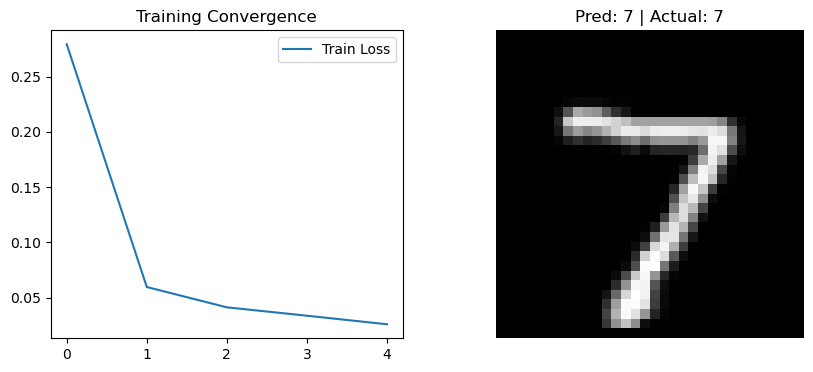

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Convergence')
plt.legend()

# Show a few sample predictions
model.eval()
images, labels = next(iter(test_loader))
outputs = model(images)
preds = outputs.argmax(dim=1)

plt.subplot(1, 2, 2)
for i in range(4):
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i]} | Actual: {labels[i]}")
    plt.axis('off')
    break # Just showing one for the subplot space
plt.show()

# Part 3: Recurrent Neural Networks (NumPy)

Now we switch to sequences. An RNN processes data one step at a time, maintaining a "hidden state".

## Question 3: The RNN Step

Implement the math for a single time-step:
$$ h_t = \tanh(X_t W_x + h_{t-1} W_h + b) $$

In [11]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of a vanilla RNN using tanh activation.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H).
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H).
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H).
    - b: Biases of shape (H,).

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    # 1.线性变换
    # np.dot 
    # x (N,D) @ Wx (D,H) -> (N,H)
    # prev_h (N,H) @ Wh (H,H) -> (N,H)
    activation = np.dot(x, Wx) + np.dot(prev_h, Wh) + b
    # 2. 非线性激活 (Tanh)
    next_h = np.tanh(activation)

    cache = (x, prev_h, Wx, Wh, b, next_h)
    return next_h, cache

In [12]:
grader.check("q3_rnn_step")

q3_rnn_step results: All test cases passed!

# Part 4: LSTM for Sentiment Analysis

Standard RNNs suffer from vanishing gradients. We will use an LSTM to classify movie reviews as Positive/Negative.

## Question 4: LSTM Classifier

We have provided a `TextPipeline` helper to handle the data processing. Your job is to build the model:

`Input Indices` -> `Embedding Layer` -> `LSTM` -> `Linear` -> `Sigmoid`

**Important:** For classification, we typically use the **last** hidden state of the sequence.

In [13]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.5):
        super(SentimentLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # 1. Embedding Layer: 将整数索引转换为密集向量
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 2. LSTM Layer
        # batch_first=True 让输入变为 (batch, seq, feature)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob if n_layers > 1 else 0,
                            batch_first=True)
        # 3. Dropout Layer 防止过拟合
        self.dropout = nn.Dropout(drop_prob)

        # 4. Fully Connected Layer (映射到输出维度，这里是 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # 5. Sigmoid (将输出压缩到 0-1 之间，用于二分类概率)
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, x):
        # x shape: (batch_size, seq_len)

        # 1. 嵌入
        embeds = self.embedding(x) # -> (batch, seq, embed_dim)

        # 2. LSTM 前向传播
        # lstm_out shape: (batch, seq_len, hidden_dim)
        # hidden shape: (n_layers, batch, hidden_dim) (这里我们不需要它)
        lstm_out, hidden = self.lstm(embeds)

        # 3. 提取最后一个时间步的输出
        # 我们只关心读完整个句子后的情感，所以取序列的最后一步
        # out[:, -1, :] 取所有 batch，最后一个 timestep，所有 hidden features
        last_hidden_state = lstm_out[:, -1, :]

        # 4. Dropout + Linear + Sigmoid
        out = self.dropout(last_hidden_state)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        return out, hidden
        

In [14]:
grader.check("q4_lstm")

q4_lstm results: All test cases passed!

## Training the LSTM (Demo)

Data shapes: Train torch.Size([800, 10]), Val torch.Size([200, 10])
Training Sentiment Model...
Epoch 10: Loss 0.3067, Val Acc 0.85
Epoch 20: Loss 0.2195, Val Acc 0.85
Epoch 30: Loss 0.1708, Val Acc 0.87
Epoch 40: Loss 0.0679, Val Acc 0.88
Epoch 50: Loss 0.0056, Val Acc 0.88


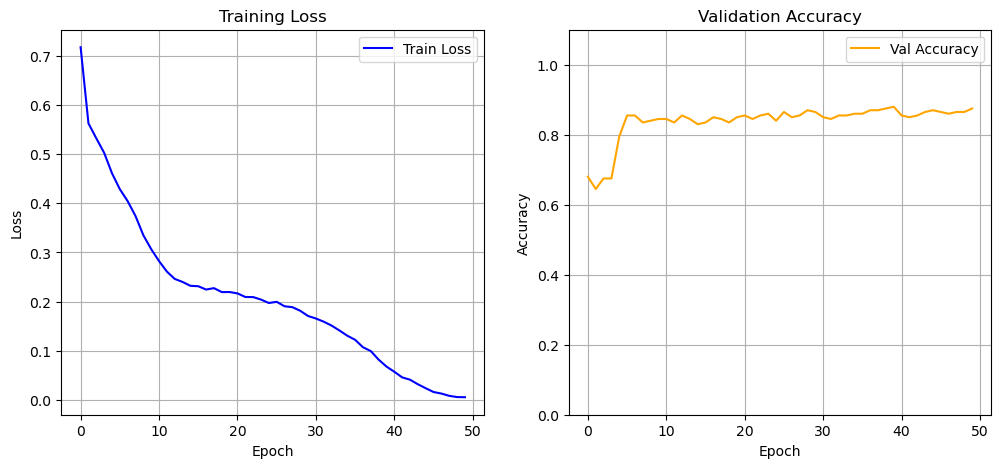

In [15]:
# 1. Generate Mock Data
texts, labels = generate_mock_imdb_data(N=1000) # Increased N for better split

# 2. Preprocess
# Reduce max_len to 10 since mock sentences are short.
# This helps the LSTM avoid processing too many padding tokens.
pipeline = SimpleTextPipeline(vocabulary_size=1000, max_len=10)
pipeline.fit(texts)
X = pipeline.transform(texts)
y = labels.unsqueeze(1) # (N, 1)

# 3. Train/Test Split (80/20)
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Data shapes: Train {X_train.shape}, Val {X_val.shape}")

# 4. Train
model = SentimentLSTM(vocab_size=1000, embedding_dim=64, hidden_dim=64, output_dim=1, n_layers=1)
optimizer = optim.Adam(model.parameters(), lr=0.01) # Increased learning rate
criterion = nn.BCELoss()

train_losses = []
val_accs = []

print("Training Sentiment Model...")
for epoch in range(50): # Increased epochs
    # --- Training Step ---
    model.train()
    optimizer.zero_grad()

    out, _ = model(X_train)
    loss = criterion(out, y_train)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # --- Validation Step ---
    model.eval()
    with torch.no_grad():
        val_out, _ = model(X_val)
        # Accuracy: threshold at 0.5
        val_acc = ((val_out > 0.5).float() == y_val).float().mean()
        val_accs.append(val_acc.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss {loss.item():.4f}, Val Acc {val_acc.item():.2f}")

# 5. Visualize
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Val Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()

plt.show()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [17]:
# Save your notebook first, then run this cell to export your submission.
#grader.export(run_tests=True)